## Step 0: Before starting the notebook


1. in the terminal from the project diectory do the following:
- python3.12 -m venv .venv
- source .venv/bin/activate
- pip install -r requirements.txt (first uncomment -e . to install it for using in the notebook)
- pip install jupyter notebook jupyterlab ipykernel
- python -m ipykernel install --user --name .venv --display-name "Python 3.12 (.venv)"
2. select the created kernel for this notebook
3. run the cells in order (some cells like data download need to run only once for the first time)






In [1]:
import sys
print(sys.executable)
print(sys.version)


/home/rbahmani/projects/load-forecasting-ml-pipeline/.venv/bin/python
3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]


In [2]:
import pandas as pd
import numpy as np
import tqdm
import os

In [3]:
os.chdir("..")


In [4]:
import os
os.getcwd()

'/home/rbahmani/projects/load-forecasting-ml-pipeline'

## Step 1: Data preparation


In [5]:
# download data
# run only once
# !kaggle datasets download jeanmidev/smart-meters-in-london -p data/smart_meters --unzip



In [6]:
path_dataset=r'data/smart_meters'
path_dataset_meters=r'data/smart_meters/halfhourly_dataset/halfhourly_dataset'

os.listdir(path_dataset)

['darksky_parameters_documentation.html',
 'daily_dataset.csv',
 'informations_households.csv',
 'uk_bank_holidays.csv',
 'hhblock_dataset',
 'halfhourly_dataset',
 'daily_dataset',
 'weather_hourly_darksky.csv',
 'weather_daily_darksky.csv',
 'acorn_details.csv']

In [7]:
import os
import pandas as pd

# this code counts the number of unique households in each file
# Uncomment and run if needed


# household_counts = {}

# for file_name in os.listdir(path_dataset_meters):
#     file_path = os.path.join(path_dataset_meters, file_name)
#     df = pd.read_csv(file_path, usecols=["LCLid"])  # load only the household column
#     n_households = df["LCLid"].nunique()
#     household_counts[file_name] = n_households


# household_counts_sorted = dict(sorted(household_counts.items()))
# household_counts_sorted


In [8]:
N = 20  # number of files you want to include. max is 112

halfhourly_dataset = []

file_list = os.listdir(path_dataset_meters)[:N]

for file_name in tqdm.tqdm(file_list):
    df_temp = pd.read_csv(os.path.join(path_dataset_meters, file_name),
                          index_col='tstp', parse_dates=True, low_memory=False)
    df_temp['file_name'] = file_name.split('.')[0]
    df_temp = df_temp.replace('Null', np.nan).dropna()
    df_temp['energy(kWh/hh)'] = df_temp['energy(kWh/hh)'].astype(float)
    halfhourly_dataset.append(df_temp)

halfhourly_dataset = pd.concat(halfhourly_dataset, axis=0)


100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


In [9]:
halfhourly_dataset.head()

,LCLid,energy(kWh/hh),file_name
tstp,,,
2011-12-07 10:00:00,MAC000022,0.255,block_94
2011-12-07 10:30:00,MAC000022,0.278,block_94
2011-12-07 11:00:00,MAC000022,0.268,block_94
2011-12-07 11:30:00,MAC000022,0.185,block_94
2011-12-07 12:00:00,MAC000022,0.186,block_94


In [10]:
halfhourly_dataset.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30123220 entries, 2011-12-07 10:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LCLid           object 
 1   energy(kWh/hh)  float64
 2   file_name       object 
dtypes: float64(1), object(2)
memory usage: 919.3+ MB


In [11]:
halfhourly_dataset['energy(kWh/hh)'].isna().sum()
halfhourly_dataset.isna().sum()


LCLid             0
energy(kWh/hh)    0
file_name         0
dtype: int64

In [12]:
# Find bad LCLids (those with ≥ 1 NaN)
bad_lclids = (
    halfhourly_dataset
    .groupby('LCLid')['energy(kWh/hh)']
    .apply(lambda x: x.isna().any())
)

bad_lclids = bad_lclids[bad_lclids].index

# How many LCLids will be dropped
num_lclids_dropped = len(bad_lclids)

# Drop them completely
halfhourly_dataset_clean = halfhourly_dataset[
    ~halfhourly_dataset['LCLid'].isin(bad_lclids)
]

# How many rows were dropped
num_rows_dropped = len(halfhourly_dataset) - len(halfhourly_dataset_clean)

# Print results
print("LCLids dropped:", num_lclids_dropped)
print("Rows dropped:", num_rows_dropped)


LCLids dropped: 0
Rows dropped: 0


In [13]:
halfhourly_dataset_clean.head()

,LCLid,energy(kWh/hh),file_name
tstp,,,
2011-12-07 10:00:00,MAC000022,0.255,block_94
2011-12-07 10:30:00,MAC000022,0.278,block_94
2011-12-07 11:00:00,MAC000022,0.268,block_94
2011-12-07 11:30:00,MAC000022,0.185,block_94
2011-12-07 12:00:00,MAC000022,0.186,block_94


In [14]:
# change based on the selected days
halfhourly_dataset_clean[
    (halfhourly_dataset_clean.index.date == pd.Timestamp("2012-07-25").date()) &
    (halfhourly_dataset_clean["LCLid"] == "MAC004618")
]

,LCLid,energy(kWh/hh),file_name
tstp,,,
2012-07-25 00:00:00,MAC004618,0.055,block_23
2012-07-25 00:30:00,MAC004618,0.067,block_23
2012-07-25 01:00:00,MAC004618,0.035,block_23
2012-07-25 01:30:00,MAC004618,0.073,block_23
2012-07-25 02:00:00,MAC004618,0.045,block_23
2012-07-25 02:30:00,MAC004618,0.052,block_23
2012-07-25 03:00:00,MAC004618,0.057,block_23
2012-07-25 03:30:00,MAC004618,0.060,block_23
2012-07-25 04:00:00,MAC004618,0.034,block_23


Find a continous period (we assumed int(365*1.1) days here) in our dataset under the following condition:
- Find a continuous days period
- Where a fixed group of LCLids
- All have data (no gaps) during that entire year

In [15]:
import pandas as pd

df = halfhourly_dataset_clean

# Daily availability: does this LCLid have ANY data that day?
daily_presence = (
    df.groupby([pd.Grouper(freq="D"), "LCLid"])
      .size()
      .unstack(fill_value=0)
)

# Convert to boolean: True = available that day
daily_presence = daily_presence > 0


In [16]:
window = int(365*1.1)

dates = daily_presence.index

best_start = None
best_end = None
best_meter_group = None
max_meter_count = 0

for i in range(len(dates) - window + 1):
    window_data = daily_presence.iloc[i:i+window]

    # Only meters that are present ALL int(365*1.1) days
    common_meters = window_data.all(axis=0)

    num_meters = common_meters.sum()

    if num_meters > max_meter_count:
        max_meter_count = num_meters
        best_start = dates[i]
        best_end = dates[i+window-1]
        best_meter_group = common_meters[common_meters].index


In [17]:
print("Best int(365*1.1) days period:")
print("Start:", best_start)
print("End:  ", best_end)
print("Meters available every day:", max_meter_count)


Best int(365*1.1) days period:
Start: 2012-11-17 00:00:00
End:   2013-12-22 00:00:00
Meters available every day: 881


In [18]:
best_meter_group


Index(['MAC000004', 'MAC000022', 'MAC000025', 'MAC000032', 'MAC000039',
       'MAC000044', 'MAC000051', 'MAC000053', 'MAC000069', 'MAC000090',
       ...
       'MAC005465', 'MAC005470', 'MAC005472', 'MAC005475', 'MAC005507',
       'MAC005511', 'MAC005524', 'MAC005540', 'MAC005544', 'MAC005562'],
      dtype='object', name='LCLid', length=881)

In [19]:
final_year_data = df[
    (df.index >= best_start) &
    (df.index <= best_end)
]

final_year_data = final_year_data[
    final_year_data["LCLid"].isin(best_meter_group)
]

In [20]:
# Build the expected half-hourly index for that year
freq = "30min"  # 'T' is deprecated; '30min' is the same as '30T'
expected_index = pd.date_range(
    start=best_start,
    end=best_end,
    freq=freq,
)
total_slots = len(expected_index)
print("Total expected slots per meter in this window:", total_slots)

# Count missing timestamps per LCLid (vectorized)
missing_counts = (
    final_year_data
    .groupby("LCLid")
    .apply(lambda g: len(expected_index.difference(g.index)))
)

print("Meters in missing_counts:", len(missing_counts))
print(missing_counts.head())

# Convert to ratio of missing points
missing_ratio = missing_counts / total_slots

print("\nMissing ratio summary:")
print(missing_ratio.describe())

# Choose a threshold: allow up to 1% missing points in the year
threshold = 0.01

good_meters = missing_ratio[missing_ratio <= threshold].index
bad_meters  = missing_ratio[missing_ratio >  threshold].index

print("\nGood meters:", len(good_meters))
print("Bad meters :", len(bad_meters))

# Keep only the good meters
final_year_data = final_year_data[final_year_data["LCLid"].isin(good_meters)]

Total expected slots per meter in this window: 19201


/tmp/ipykernel_272413/1077555301.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: len(expected_index.difference(g.index)))


Meters in missing_counts: 881
LCLid
MAC000004    1
MAC000022    1
MAC000025    7
MAC000032    1
MAC000039    9
dtype: int64

Missing ratio summary:
count    881.000000
mean       0.000518
std        0.001135
min        0.000000
25%        0.000052
50%        0.000104
75%        0.000365
max        0.015051
dtype: float64

Good meters: 879
Bad meters : 2


Quantify how bad each meter is

In [21]:
# We now have:
# final_year_data: index = tstp (DatetimeIndex), columns include LCLid and energy(kWh/hh)

# Reset index so we can reindex per meter safely
final_year_data_reset = final_year_data.reset_index().rename(columns={"index": "tstp"})

def reindex_and_impute(g):
    # g: data for one LCLid
    # 1) reindex to the full expected time grid
    g = g.set_index("tstp").reindex(expected_index)

    # 2) work on the energy series
    s = g["energy(kWh/hh)"]

    # 2a) try same time previous week (7 days * 48 half-hours)
    s = s.fillna(s.shift(48 * 7))

    # 2b) time interpolation
    s = s.interpolate(method="time")

    # 2c) forward/backward fill as last resort
    s = s.ffill().bfill()

    g["energy(kWh/hh)"] = s

    # 3) restore LCLid (it is constant for the group)
    g["LCLid"] = g["LCLid"].fillna(g["LCLid"].iloc[0])

    return g

year_imputed = (
    final_year_data_reset
    .groupby("LCLid", group_keys=False)
    .apply(reindex_and_impute)
)

# 1) Give the index a name (it's timestamp index)
year_imputed.index.name = "tstp"

# 2) Sort by LCLid and time
year_imputed = year_imputed.sort_values(["LCLid", "tstp"])

final_year_data
print("Any NaNs left in imputed year?",
      year_imputed["energy(kWh/hh)"].isna().any())

print("Shape of year_imputed:", year_imputed.shape)
print("Meters:", year_imputed["LCLid"].nunique())

print(year_imputed.head())
print(year_imputed.index.name)
print(year_imputed["LCLid"].nunique())


/tmp/ipykernel_272413/2799571583.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reindex_and_impute)


Any NaNs left in imputed year? False
Shape of year_imputed: (16877679, 3)
Meters: 879
                         LCLid  energy(kWh/hh) file_name
tstp                                                    
2012-11-17 00:00:00  MAC000004           0.000  block_39
2012-11-17 00:30:00  MAC000004           0.000  block_39
2012-11-17 01:00:00  MAC000004           0.177  block_39
2012-11-17 01:30:00  MAC000004           0.000  block_39
2012-11-17 02:00:00  MAC000004           0.000  block_39
tstp
879


In [22]:
# Create MultiIndex using (timestamp, LCLid)
f_tmp = year_imputed.copy()
h_tmp = halfhourly_dataset.copy()

f_tmp = f_tmp.reset_index().set_index(["tstp", "LCLid"]).sort_index()
h_tmp = h_tmp.reset_index().set_index(["tstp", "LCLid"]).sort_index()

# Only keep common index values
common_idx = f_tmp.index.intersection(h_tmp.index)

f_common = f_tmp.loc[common_idx]
h_common = h_tmp.loc[common_idx]

# Keep only common columns
common_cols = f_common.columns.intersection(h_common.columns)

f_common = f_common[common_cols]
h_common = h_common[common_cols]

# Final comparison
row_diff_mask = (f_common != h_common).any(axis=1)

print("Rows with same (tstp, LCLid) but different values:", row_diff_mask.sum())

# Also print index-only differences
only_in_final = f_tmp.index.difference(h_tmp.index)
only_in_half  = h_tmp.index.difference(f_tmp.index)

print("Rows only in year_imputed (by tstp+LCLid):", len(only_in_final))
print("Rows only in halfhourly_dataset (by tstp+LCLid):", len(only_in_half))


Rows with same (tstp, LCLid) but different values: 0
Rows only in year_imputed (by tstp+LCLid): 8220
Rows only in halfhourly_dataset (by tstp+LCLid): 13253778


After this:

- No NaNs inside your int(365*1.1) days window

- All meters share the same timestamps

- The imputation is “energy-time-series aware” (using weekly pattern)

In [23]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences



# OPTIONAL (nice plots, like in the docs)
from utilsforecast.plotting import plot_series


In [24]:
year_imputed = year_imputed.drop(columns=["file_name"])

# 0) make sure tstp is a column (not index)
df_tmp = year_imputed.reset_index()   # columns: tstp, LCLid, energy(kWh/hh)
df_tmp["tstp"] = pd.to_datetime(df_tmp["tstp"])

# 1) Aggregate from 30-min → hourly (sum 2 half-hours per hour, per LCLid)
hourly_dataset = (
    df_tmp
      .groupby(
          ["LCLid", pd.Grouper(key="tstp", freq="h")]
      )["energy(kWh/hh)"]
      .sum()
      .reset_index()
)



In [25]:
# Get all unique houses
unique_houses = hourly_dataset["LCLid"].unique()

group_size = 20

# Split into groups of group_size (last group may be smaller)
house_groups = [
    unique_houses[i:i + group_size]
    for i in range(0, len(unique_houses), group_size)
]

aggregated_groups = []

for idx, group in enumerate(house_groups):

    agg = (
        hourly_dataset[hourly_dataset["LCLid"].isin(group)]
            .groupby("tstp", as_index=False)["energy(kWh/hh)"]
            .sum()
    )

    # assign a group ID
    agg["unique_id"] = f"group_{idx+1}"

    aggregated_groups.append(agg)


# Combine all aggregated groups into one dataframe
df_mlf = pd.concat(aggregated_groups)

In [26]:
# 3) Rename columns to mlforecast convention
df_mlf = df_mlf.rename(columns={
    "LCLid": "unique_id",
    "tstp": "ds",
    "energy(kWh/hh)": "y",
})

# 4) Sort & ensure datetime
df_mlf["ds"] = pd.to_datetime(df_mlf["ds"])
df_mlf = df_mlf.sort_values(["unique_id", "ds"])

df_mlf.head()

,ds,y,unique_id
0,2012-11-17 00:00:00,15.947,group_1
1,2012-11-17 01:00:00,15.799,group_1
2,2012-11-17 02:00:00,9.917,group_1
3,2012-11-17 03:00:00,6.708,group_1
4,2012-11-17 04:00:00,4.975,group_1


In [27]:
df_mlf.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

In [28]:
df_mlf


,ds,y,unique_id
0,2012-11-17 00:00:00,15.947,group_1
1,2012-11-17 01:00:00,15.799,group_1
2,2012-11-17 02:00:00,9.917,group_1
3,2012-11-17 03:00:00,6.708,group_1
4,2012-11-17 04:00:00,4.975,group_1
...,...,...,...
9596,2013-12-21 20:00:00,10.107,group_9
9597,2013-12-21 21:00:00,9.166,group_9
9598,2013-12-21 22:00:00,8.707,group_9
9599,2013-12-21 23:00:00,7.036,group_9


In [29]:
df_mlf['y'].describe()


count    422444.000000
mean          8.181249
std           3.907528
min           1.395000
25%           5.295000
50%           7.413000
75%          10.241000
max          38.338000
Name: y, dtype: float64

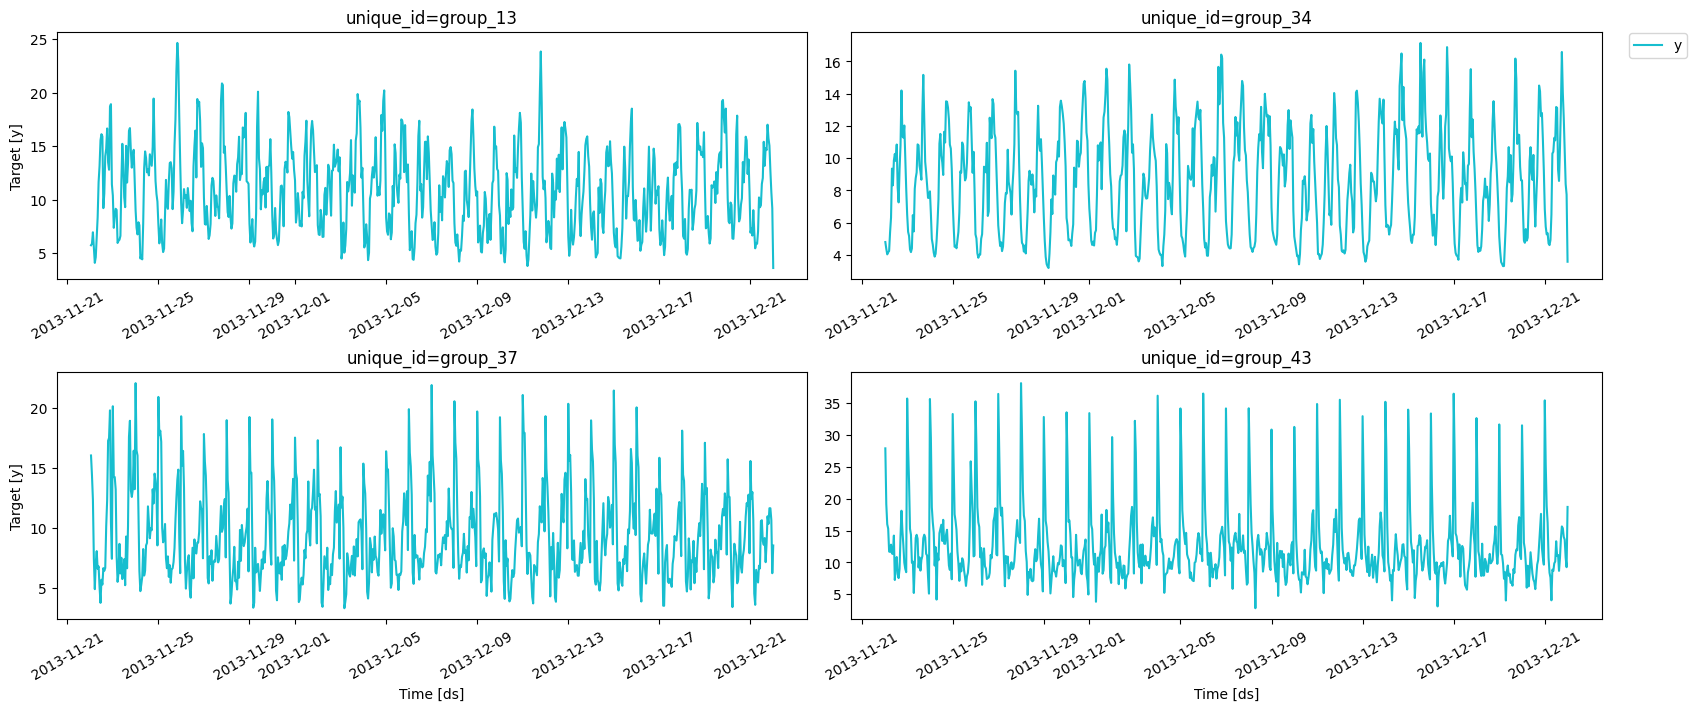

In [30]:
# pick a small sample of series to visualize
uids = df_mlf['unique_id'].unique()
np.random.seed(0)
sample_uids = np.random.choice(uids, size=4, replace=False)

df_eda = df_mlf[df_mlf['unique_id'].isin(sample_uids)].reset_index(drop=True)

# Plot 2 weeks of history (24hours * 14)
fig = plot_series(df_eda, max_insample_length=24 * 30)
fig  # <- last line, no plt.show() and no fig.show()


In [31]:
# example for differencing on this dataset
fcst_diff = MLForecast(
    models=[],                 # no model yet, just preprocessing
    freq='H',
    target_transforms=[Differences([24])]  # subtract value from same time yesterday
)

prep_diff = fcst_diff.preprocess(df_mlf)
prep_diff.head()


,ds,y,unique_id
24,2012-11-18 00:00:00,-6.238,group_1
25,2012-11-18 01:00:00,-4.612,group_1
26,2012-11-18 02:00:00,-2.541,group_1
27,2012-11-18 03:00:00,0.119,group_1
28,2012-11-18 04:00:00,-0.583,group_1


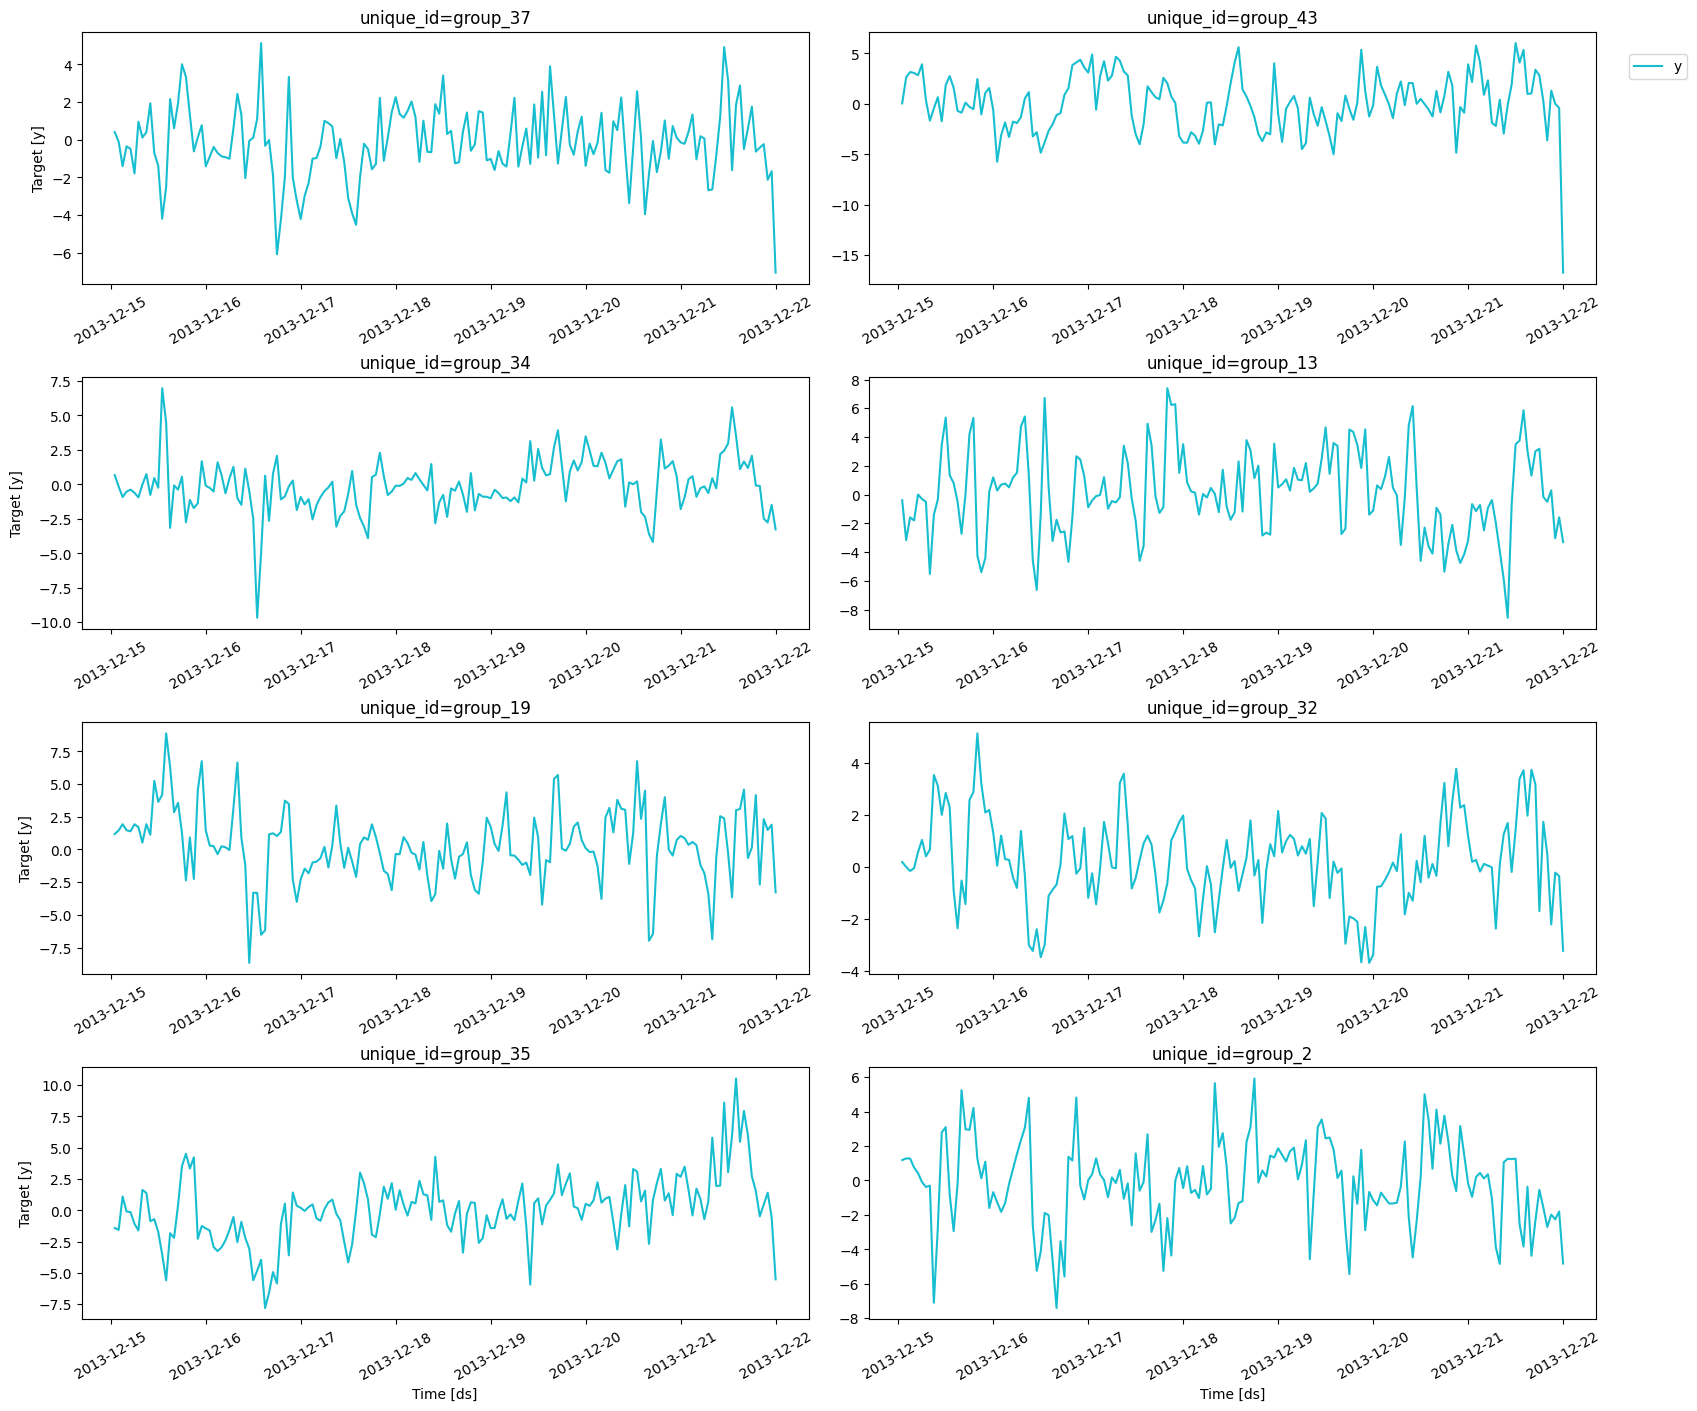

In [32]:
fig = plot_series(prep_diff, max_insample_length=24 * 7)
fig

Holidays data

In [33]:
# df_holiday: raw bank holiday file
df_holiday = pd.read_csv(os.path.join(path_dataset, 'uk_bank_holidays.csv'))
df_holiday['Bank holidays'] = pd.to_datetime(df_holiday['Bank holidays'])
df_holiday = df_holiday.rename(columns={'Bank holidays': 'date'})
df_holiday.head()

,date,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [34]:
df_holiday['is_holiday'] = 1
df_holiday = df_holiday[['date', 'is_holiday']]

# attach to df_mlf (hourly load)
df_mlf['date'] = df_mlf['ds'].dt.normalize()
df_mlf = df_mlf.merge(df_holiday, on='date', how='left')

df_mlf['is_holiday'] = df_mlf['is_holiday'].fillna(0).astype(int)
df_mlf = df_mlf.drop(columns='date')
df_mlf.head()

,ds,y,unique_id,is_holiday
0,2012-11-17 00:00:00,15.947,group_1,0
1,2012-11-17 01:00:00,15.799,group_1,0
2,2012-11-17 02:00:00,9.917,group_1,0
3,2012-11-17 03:00:00,6.708,group_1,0
4,2012-11-17 04:00:00,4.975,group_1,0


Weather data

In [35]:
# read full weather table once
weather_hourly_darksky = pd.read_csv(
    os.path.join(path_dataset, 'weather_hourly_darksky.csv'),
    index_col='time',
    parse_dates=True
).sort_index()
weather_hourly_darksky.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-01 00:00:00,13.63,160,13.49,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear
2011-11-01 01:00:00,13.26,154,12.73,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Partly Cloudy
2011-11-01 02:00:00,12.94,161,13.65,12.14,1007.09,13.65,3.71,rain,clear-night,0.91,Clear
2011-11-01 03:00:00,12.99,170,14.13,12.24,1006.50,14.13,3.95,rain,partly-cloudy-night,0.88,Partly Cloudy
2011-11-01 04:00:00,12.92,180,14.17,12.59,1006.14,14.17,3.97,rain,partly-cloudy-night,0.90,Partly Cloudy


In [36]:
# select only numeric weather features automatically
WEATHER_FEATURES = weather_hourly_darksky.select_dtypes(
    include=["float64", "int64"]
).columns.tolist()

weather_cols = [c for c in WEATHER_FEATURES if c in weather_hourly_darksky.columns]

weather_feats = (
    weather_hourly_darksky[weather_cols]
        .reset_index()
        .rename(columns={'time': 'ds'})
)

df_mlf = df_mlf.merge(weather_feats, on='ds', how='left')

for col in weather_cols:
    df_mlf[col] = df_mlf[col].ffill().bfill()


In [37]:
print("Any NaNs left after merging weather?", df_mlf.isnull().sum().any())
df_mlf.head()

Any NaNs left after merging weather? False


,ds,y,unique_id,is_holiday,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
0,2012-11-17 00:00:00,15.947,group_1,0,4.84,157.0,9.79,9.15,1008.01,8.63,2.42,0.96
1,2012-11-17 01:00:00,15.799,group_1,0,3.91,168.0,10.23,9.31,1007.29,10.23,3.12,0.94
2,2012-11-17 02:00:00,9.917,group_1,0,3.93,182.0,10.46,9.83,1006.90,10.46,2.88,0.96
3,2012-11-17 03:00:00,6.708,group_1,0,2.69,186.0,10.96,10.42,1006.45,10.96,2.82,0.96
4,2012-11-17 04:00:00,4.975,group_1,0,2.12,189.0,11.54,10.96,1005.74,11.54,3.52,0.96


## Step 2: Model training and validation


In [38]:
import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [39]:
import lightgbm as lgb

lgb_params = {'verbosity': -1, 'num_leaves': 512}
# Model dictionary
models ={
        'lgbm': lgb.LGBMRegressor(**lgb_params),
        # 'lasso': Lasso(),
        'lin_reg': LinearRegression(),
        # 'ridge': Ridge(),
        # 'knn': KNeighborsRegressor(),
        # 'mlp': MLPRegressor(), 
        # 'rf': RandomForestRegressor()
    }
fcst = MLForecast(
    models= models,
    target_transforms=[Differences([24])],
    freq='h',
    lags=[1, 24, 24*7],
    lag_transforms={  
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=['hour', 'dayofweek']
)


DYNAMIC_COLS = ['is_holiday'] + ['temperature']   # all exogenous features
STATIC_COLS  = []

df_mlf = df_mlf[['unique_id', 'ds', 'y'] + DYNAMIC_COLS + STATIC_COLS]
fcst.fit(
    df_mlf,
    static_features=STATIC_COLS,   # <-- key line
)

MLForecast(models=[lgbm, lin_reg], freq=h, lag_features=['lag1', 'lag24', 'lag168', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=['hour', 'dayofweek'], num_threads=1)

In [40]:
fcst.ts.features_order_

['is_holiday',
 'temperature',
 'lag1',
 'lag24',
 'lag168',
 'expanding_mean_lag1',
 'rolling_mean_lag24_window_size48',
 'hour',
 'dayofweek']

In [41]:
import pandas as pd

h = 24  

# Last timestamp in training data
last_ds = df_mlf['ds'].max()
uids = df_mlf['unique_id'].unique()

# 1) Build future time index
future_ds = pd.date_range(
    last_ds + pd.Timedelta(hours=1),
    periods=h,
    freq='h',
)

# 2) All (unique_id, future time) combinations
base_future = (
    pd.MultiIndex.from_product([uids, future_ds])
    .to_frame(index=False)
    .rename(columns={0: 'unique_id', 1: 'ds'})
)

# 3) Get ACTUAL future weather (not last known value!)
future_weather = weather_hourly_darksky[
    weather_hourly_darksky.index > last_ds
].head(h)[['temperature']].reset_index().rename(columns={'time': 'ds'})

# 4) Get future holidays
future_holidays = pd.DataFrame({'ds': future_ds})
future_holidays['date'] = future_holidays['ds'].dt.normalize()
future_holidays = future_holidays.merge(
    df_holiday[['date', 'is_holiday']], 
    on='date', 
    how='left'
)
future_holidays['is_holiday'] = future_holidays['is_holiday'].fillna(0).astype(int)
future_holidays = future_holidays[['ds', 'is_holiday']]

# 5) Merge by timestamp
future_exog = future_weather.merge(future_holidays, on='ds', how='left')

# 6) Attach to all series
exog_future = base_future.merge(future_exog, on='ds', how='left')

# 7) Predict
preds = fcst.predict(h=h, X_df=exog_future)
preds.head()


,unique_id,ds,lgbm,lin_reg
0,group_1,2013-12-22 01:00:00,6.467145,6.905146
1,group_1,2013-12-22 02:00:00,5.933674,5.569000
2,group_1,2013-12-22 03:00:00,6.244259,6.239988
3,group_1,2013-12-22 04:00:00,4.685632,6.306116
4,group_1,2013-12-22 05:00:00,4.753311,5.979655


In [52]:
df_mlf.head()

,unique_id,ds,y,is_holiday,temperature
0,group_1,2012-11-17 00:00:00,15.947,0,9.79
1,group_1,2012-11-17 01:00:00,15.799,0,10.23
2,group_1,2012-11-17 02:00:00,9.917,0,10.46
3,group_1,2012-11-17 03:00:00,6.708,0,10.96
4,group_1,2012-11-17 04:00:00,4.975,0,11.54


In [ ]:
cv_result = fcst.cross_validation(
    df=df_mlf[['unique_id', 'ds', 'y']],  # Target data only
    X_df=df_mlf[['unique_id', 'ds'] + DYNAMIC_COLS],  # Exogenous features
    n_windows=6,
    h=24,
    static_features=STATIC_COLS,
)


## Step 3: Results


In [43]:
cv_result


,unique_id,ds,cutoff,y,lgbm,lin_reg
0,group_1,2013-12-16 01:00:00,2013-12-16,9.985,10.622052,10.803078
1,group_1,2013-12-16 02:00:00,2013-12-16,5.494,7.222928,7.239177
2,group_1,2013-12-16 03:00:00,2013-12-16,5.585,7.017660,6.863239
3,group_1,2013-12-16 04:00:00,2013-12-16,6.540,5.730887,5.591577
4,group_1,2013-12-16 05:00:00,2013-12-16,6.023,5.620715,4.874731
...,...,...,...,...,...,...
6331,group_9,2013-12-21 20:00:00,2013-12-21,10.107,10.404583,11.061912
6332,group_9,2013-12-21 21:00:00,2013-12-21,9.166,9.681987,10.247151
6333,group_9,2013-12-21 22:00:00,2013-12-21,8.707,8.452879,8.915598
6334,group_9,2013-12-21 23:00:00,2013-12-21,7.036,6.573523,6.759350


In [44]:
group_1_cv = cv_result[cv_result['unique_id'] == 'group_1']
group_1_cv

,unique_id,ds,cutoff,y,lgbm,lin_reg
0,group_1,2013-12-16 01:00:00,2013-12-16,9.985,10.622052,10.803078
1,group_1,2013-12-16 02:00:00,2013-12-16,5.494,7.222928,7.239177
2,group_1,2013-12-16 03:00:00,2013-12-16,5.585,7.017660,6.863239
3,group_1,2013-12-16 04:00:00,2013-12-16,6.540,5.730887,5.591577
4,group_1,2013-12-16 05:00:00,2013-12-16,6.023,5.620715,4.874731
...,...,...,...,...,...,...
5299,group_1,2013-12-21 20:00:00,2013-12-21,13.270,13.624239,14.184628
5300,group_1,2013-12-21 21:00:00,2013-12-21,9.823,12.014975,12.731847
5301,group_1,2013-12-21 22:00:00,2013-12-21,8.072,10.920968,11.436256
5302,group_1,2013-12-21 23:00:00,2013-12-21,8.439,9.517815,10.205042


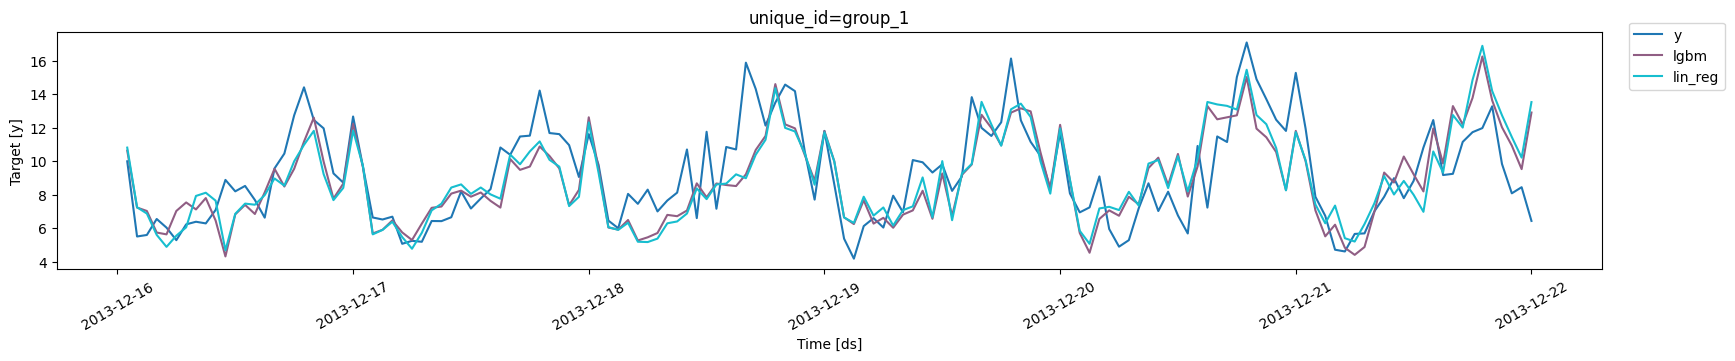

In [45]:
fig = plot_series(forecasts_df=group_1_cv.drop(columns='cutoff'))
fig

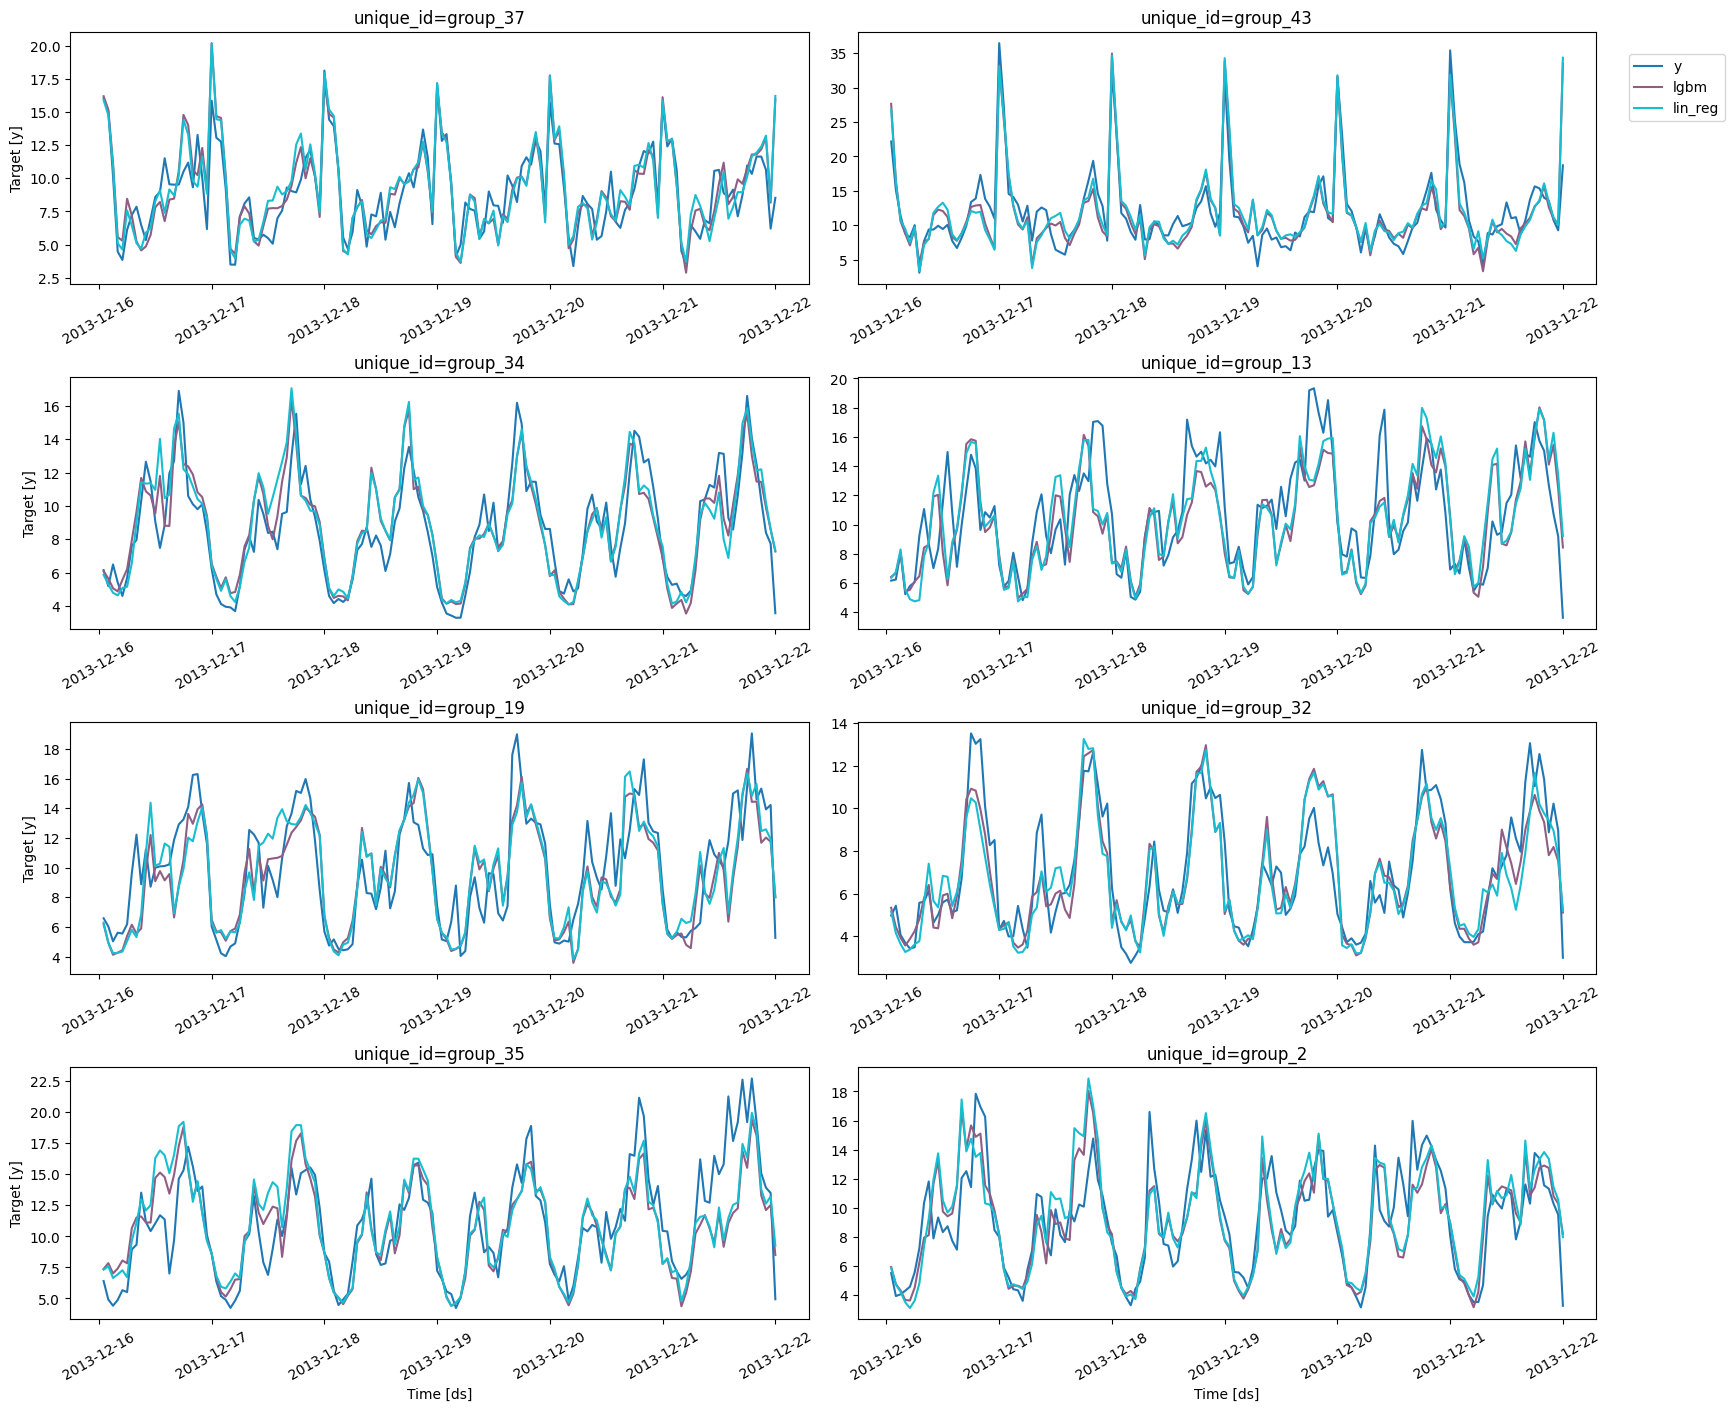

In [46]:
fig = plot_series(forecasts_df=cv_result.drop(columns='cutoff'))
fig

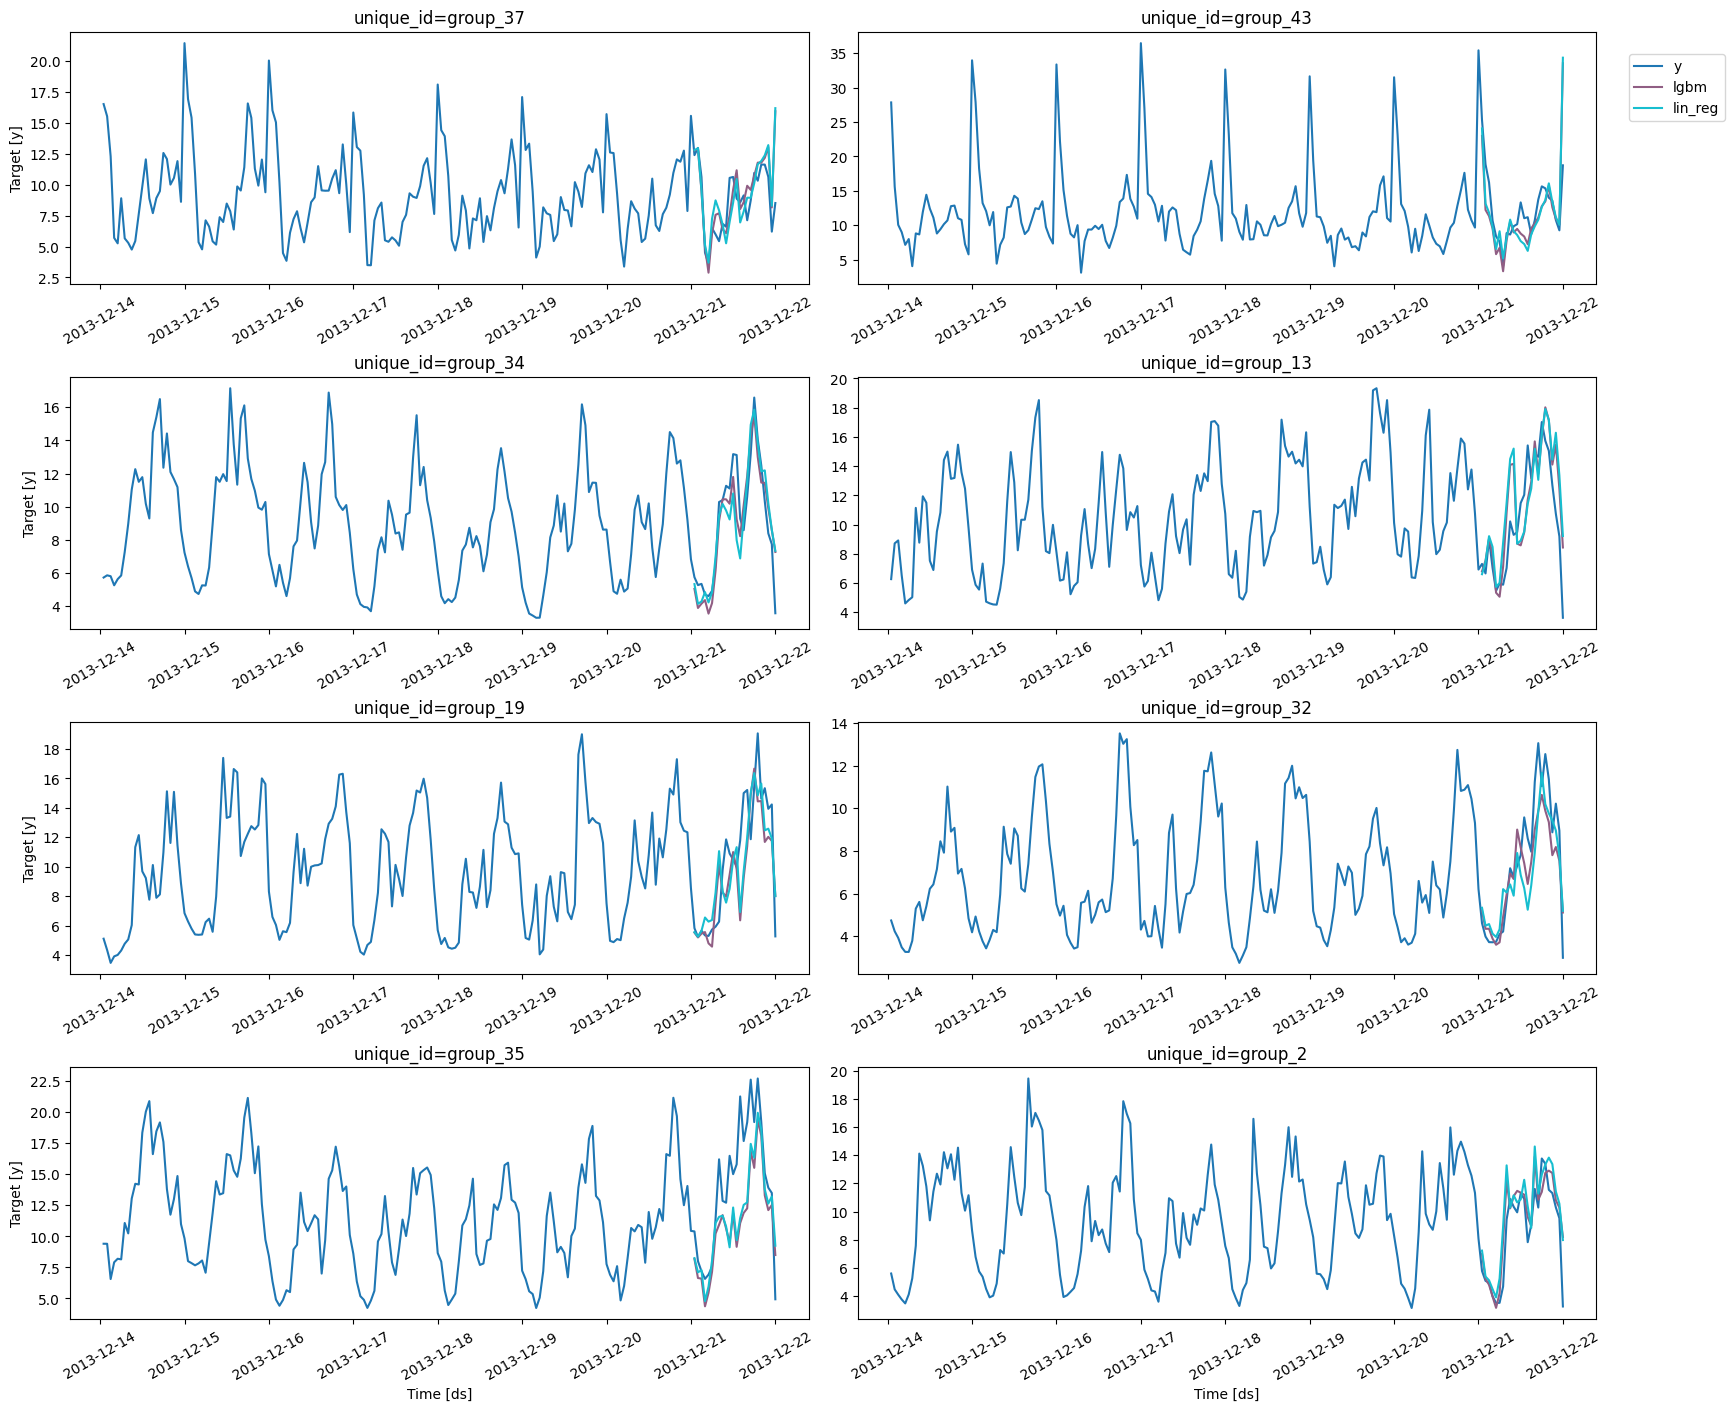

In [47]:
last_cutoff = cv_result['cutoff'].max()
cv_last = cv_result[cv_result['cutoff'] == last_cutoff]

# 1. Keep ONLY real history up to the cutoff
hist = df_mlf[df_mlf['ds'] <= last_cutoff].copy()

# 2. From that, keep only the last 7 days per series
hist = (
    hist.sort_values(['unique_id', 'ds'])
        .groupby('unique_id', group_keys=False)
        .tail(7*24)   # 7 days of hourly data
)

# 3. Plot history + forecasts
fig = plot_series(
    hist,
    forecasts_df=cv_last.drop(columns='cutoff'),
)
fig


In [48]:
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

In [49]:
# Metrics to be used for evaluation
metrics = [
    mae,
    rmse,
    mape,
    smape
]

In [50]:
# Function to evaluate the crossvalidation
def evaluate_crossvalidation(crossvalidation_df, metrics, models):
    evaluations = []
    for c in crossvalidation_df['cutoff'].unique():
        df_cv = crossvalidation_df.query('cutoff == @c')
        evaluation = evaluate(
            df = df_cv,
            metrics=metrics,
            models=list(models.keys())
            )
        evaluations.append(evaluation)
    evaluations = pd.concat(evaluations, ignore_index=True).drop(columns='unique_id')
    evaluations = evaluations.groupby('metric').mean()
    return evaluations.style.background_gradient(cmap='RdYlGn_r', axis=1)

In [51]:
evaluate_crossvalidation(cv_result, metrics, models)

,cutoff,lgbm,lin_reg
metric,,,
mae,2013-12-18 12:00:00,1.445327,1.534960
mape,2013-12-18 12:00:00,0.169181,0.181924
rmse,2013-12-18 12:00:00,1.892215,2.004788
smape,2013-12-18 12:00:00,0.082039,0.086948
